# Импорт библиотек

In [1]:
from google.colab.patches import cv2_imshow

In [2]:
import numpy as np
import requests
import cv2

# Загрузка изображения

In [3]:
def download_and_read_image(url: str) -> np.ndarray:
    # Скачать изображение
    response = requests.get(url)
    response.raise_for_status()  # Проверка на ошибки при загрузке

    # Преобразовать содержимое в массив numpy
    image_array = np.frombuffer(response.content, np.uint8)

    # Прочитать изображение в формате OpenCV
    image = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
    if image is None:
        raise ValueError("Не удалось считать изображение.")
    return image

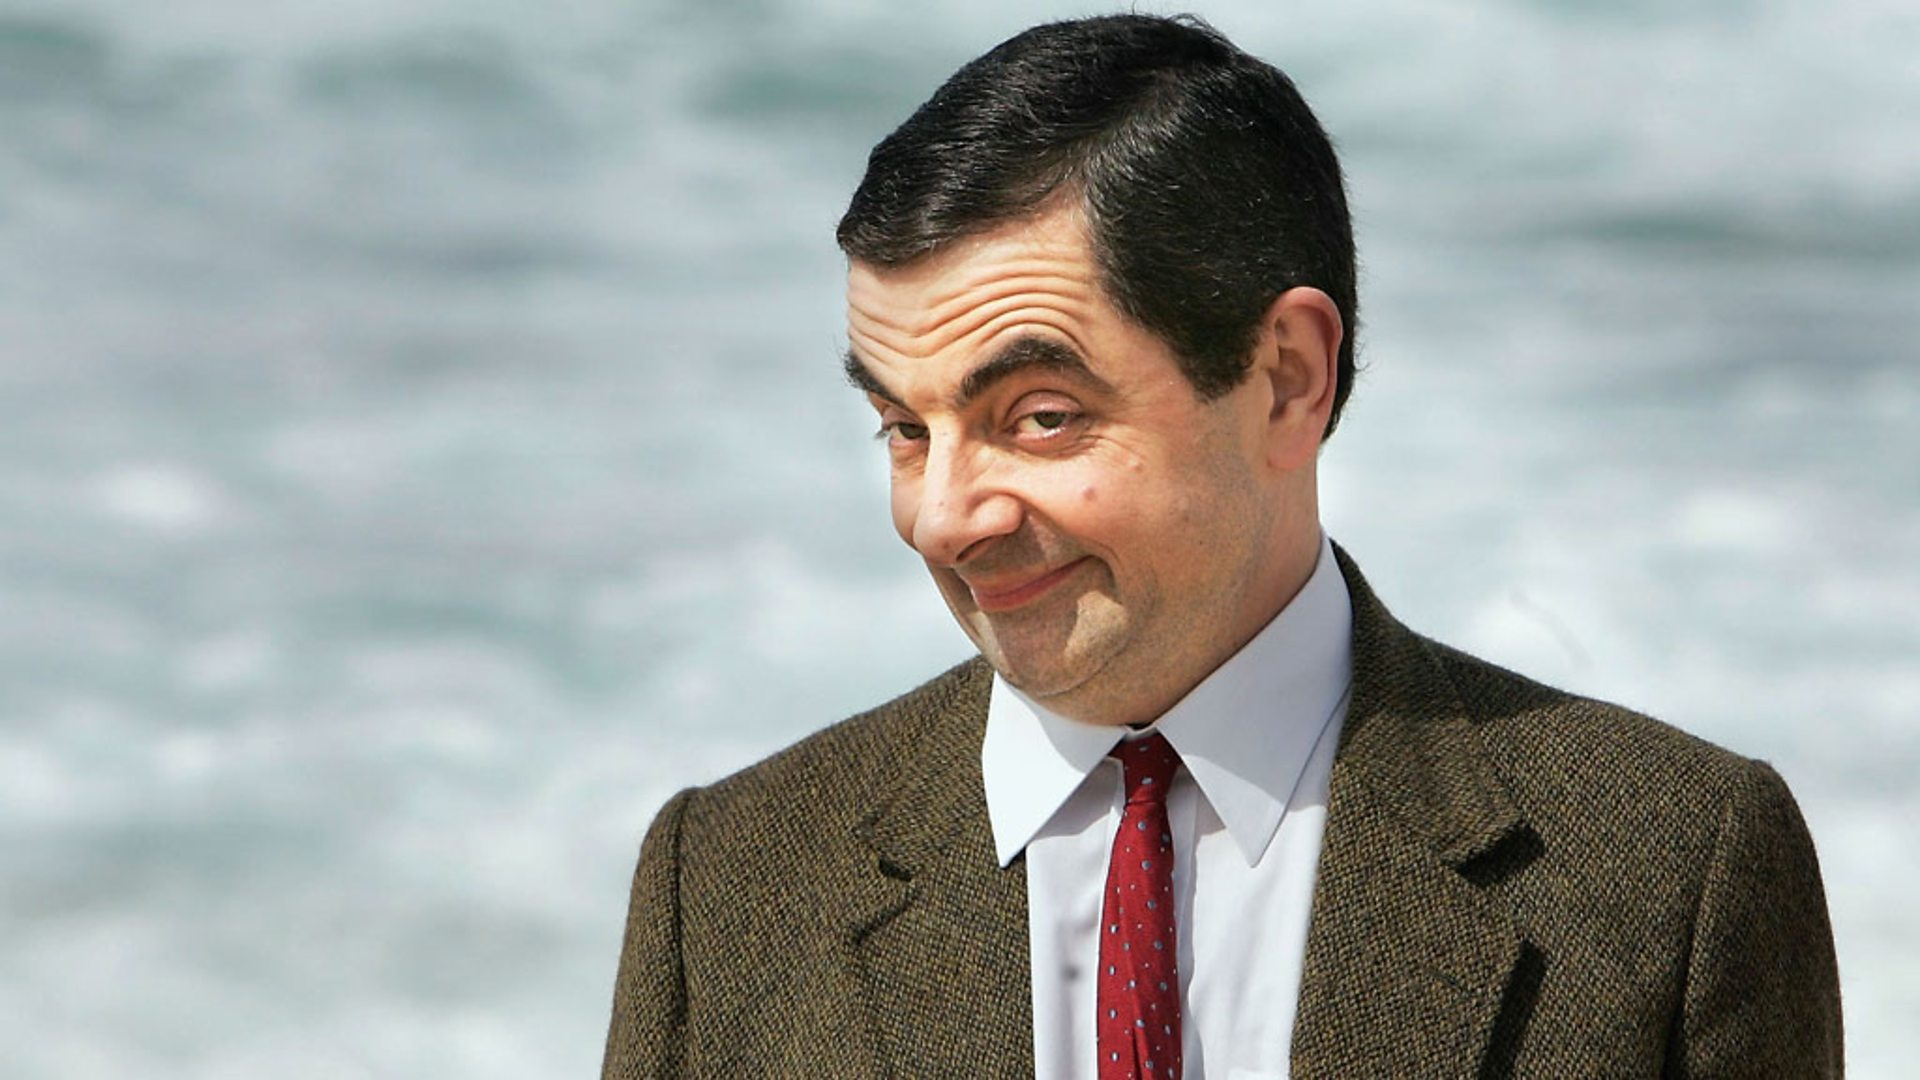

(1080, 1920, 3)

In [4]:
url = "https://naked-science.ru/wp-content/uploads/2020/01/mrbean_1.jpg"

img = download_and_read_image(url)

cv2_imshow(img)
img.shape

##  Изменение разрешения изображений

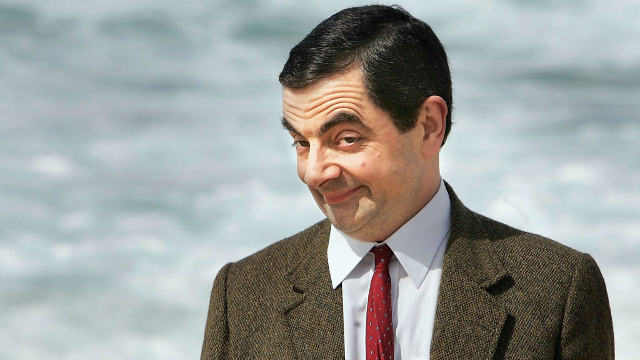

(360, 640, 3)

In [5]:
image = cv2.resize(img, (640, 360)) # Изменение разрешения изображения для повышения скорости вычесления
cv2_imshow(image)
image.shape

# Лабораторная работа №1

> Необходимо считать изображение, применить написанные функции для выполнения
* Эрозия, Дилатация
* Медианный фильтр, фильтр Гаусса
* Бинаризация изображения
* Корректировка освещения


## Фильтры

### Сглаживание по гауссу

In [6]:
def gaussian_filter(
        image: np.ndarray,  # Исходное изображение (3D массив)
        kernel_size: int,   # Размер ядра фильтра
        sigma: float,       # Стандартное отклонение Гаусса
        ) -> np.ndarray:

    # Создание ядра Гаусса
    ax = np.linspace(-(kernel_size // 2), kernel_size // 2, kernel_size)
    gauss = np.exp(-0.5 * np.square(ax) / np.square(sigma))
    kernel = np.outer(gauss, gauss)
    kernel /= np.sum(kernel)

    # Применение ядра
    pad = kernel_size // 2

    padded_image = np.pad(
        image,
        pad_width=((pad, pad), (pad, pad), (0, 0)), # Паддинг только по высоте и ширине
        )

    smoothed_image = np.zeros_like(image)

    for channel in range(image.shape[2]):
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                region = padded_image[i:i + kernel_size, j:j + kernel_size, channel]
                smoothed_image[i, j, channel] = np.clip(np.sum(region * kernel), 0, 255)

    return smoothed_image   # Сглаженное изображение

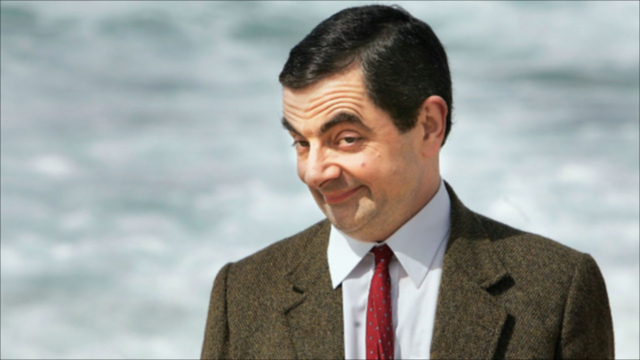

In [14]:
kernel_size = 3  # Размер ядра
sigma = 0.3 * ((kernel_size - 1) * 0.5 - 1) + 0.8  # Стандартное отклонение
smoothed_image = gaussian_filter(image, kernel_size, sigma)
cv2_imshow(smoothed_image)

### Медианный фильтр

In [8]:
def median_filter(
        image: np.ndarray,      # Исходное изображение (3D массив)
        kernel_size: int = 3,   # Размер ядра для медианного фильтра
        ) -> np.ndarray:

    # Создание ядра для медианного фильтра
    kernel = np.ones(
        shape=(kernel_size, kernel_size),
        dtype=np.uint8,
        order=None
        )

    # Применение ядра
    pad = kernel_size // 2

    padded_image = np.pad(
        image,
        pad_width=((pad, pad), (pad, pad), (0, 0)), # Паддинг только по высоте и ширине
        )
    median_image = np.zeros_like(image) # быстрее чем писать np.zeros...

    for channel in range(image.shape[2]):
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                region = padded_image[i:i + kernel_size, j:j + kernel_size, channel]
                median_image[i, j, channel] = np.median(region * kernel)

    return median_image

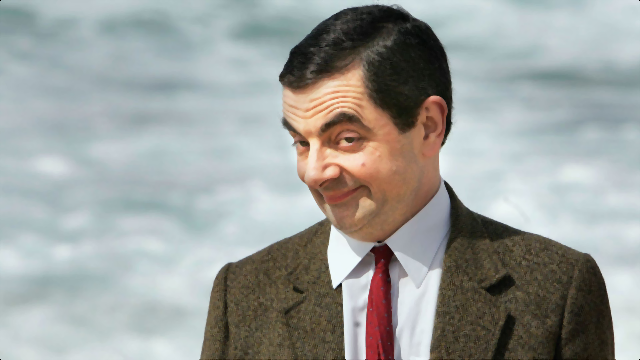

In [13]:
median_image = median_filter(image, kernel_size=3)
cv2_imshow(median_image)

## Морфологические операции

### Эрозия

In [16]:
def erode(
        image: np.ndarray,      # Исходное изображение (3D массив)
        kernel_size: int = 3    # Размер ядра для эрозии
        ) -> np.ndarray:

    pad = kernel_size // 2
    padded_image = np.pad(
        image,
        pad_width=((pad, pad), (pad, pad), (0, 0)),
        mode='constant', constant_values=255  # padding со значением 255 для белых пикселей
    )

    eroded_image = np.zeros_like(image)

    for channel in range(image.shape[2]):
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                # Применяем операцию эрозии: минимальное значение внутри ядра
                eroded_image[i, j, channel] = np.min(
                    image[i:i + kernel_size, j:j + kernel_size, channel]
                )

    return eroded_image     # Изображение после эрозии

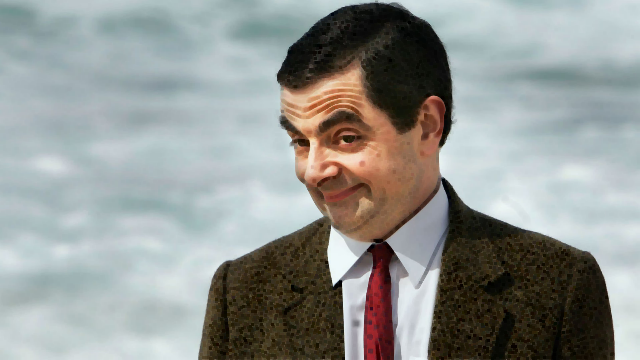

In [26]:
eroded_image = erode(image, kernel_size=3)
cv2_imshow(eroded_image)

### Дилатация

In [18]:
def dilate(
        image: np.ndarray,      # Исходное изображение (3D массив)
        kernel_size: int = 15   # Размер ядра для дилатации
        ) -> np.ndarray:

    pad = kernel_size // 2
    padded_image = np.pad(
        image,
        pad_width=((pad, pad), (pad, pad), (0, 0)),
        mode='constant', constant_values=0  # padding со значением 0 для черных пикселей
    )

    dilated_image = np.zeros_like(image)

    for channel in range(image.shape[2]):
        for i in range(1, image.shape[0]):
            for j in range(image.shape[1]):
                # Применяем операцию эрозии: минимальное значение внутри ядра
                dilated_image[i, j, channel] = np.max(
                    padded_image[i:i + kernel_size, j:j + kernel_size, channel]
                )

    return dilated_image    # Изображение после дилатации

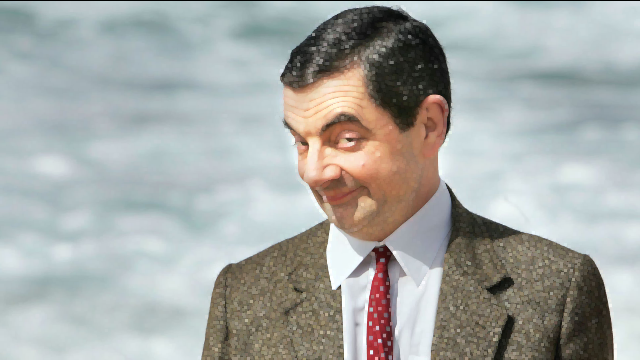

In [25]:
dilated_image = dilate(image, kernel_size=3)
cv2_imshow(dilated_image)

## Бинаризация изображения

In [20]:
def binarize(
        image: np.ndarray,                    # Исходное изображение (3D массив)
        threshold: tuple = (128, 128, 128),   # Порог бинааризации
        ) -> np.ndarray:

    binarized_img = np.ones_like(image) * 255

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            pixel = image[i, j]
            for index, channel_val in enumerate(pixel):
                if channel_val <= threshold[index]:
                    binarized_img[i, j] = 0
                    break

    return binarized_img   # Изображение после бинаризации

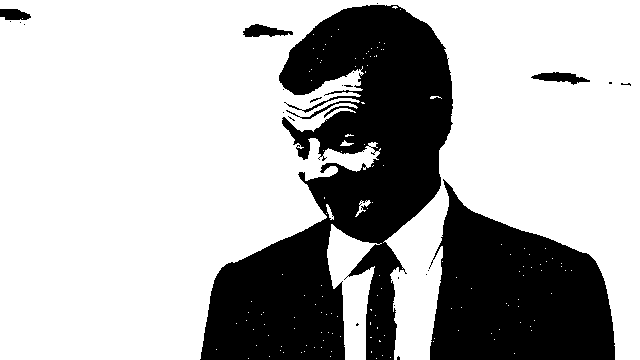

In [21]:
mask = binarize(
    image,
    threshold=(128, 128, 128),
    )
cv2_imshow(mask)

## Коррекция освещения

In [22]:
# Выравнивание гистограммы через HSV (только канал яркости)

def equalize_histogram_bgr(
            image: np.ndarray   # Исходное изображение (3D массив)
            ) -> np.ndarray:

    # Конвертация в HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Выравнивание канала V
    v_channel = hsv[..., 2]
    hist = np.histogram(v_channel, bins=256, range=(0,255))[0]
    cdf = hist.cumsum()
    cdf = (cdf - cdf.min()) / (cdf.max() - cdf.min() + 1e-7) * 255
    hsv[..., 2] = np.clip(np.interp(v_channel, np.arange(256), cdf), 0, 255).astype(np.uint8)

    # Обратная конвертация
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

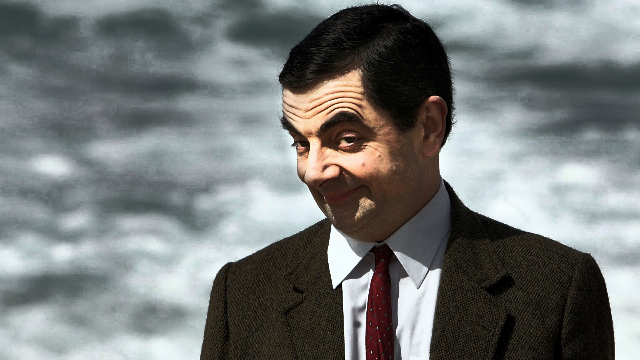

In [23]:
eq_hist = equalize_histogram_bgr(image)
cv2_imshow(eq_hist)